In [5]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# 데이터 로드
train_data = pd.read_excel('감성대화말뭉치(최종데이터)_Training.xlsx')
validation_data = pd.read_excel('감성대화말뭉치(최종데이터)_Validation.xlsx')

# 불용어 리스트
stopwords = set(['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'])

# 텍스트 정규화 함수
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()  # 소문자 변환
    text = text.replace("[^가-ㅎㅏ-ㅣ가-힣 ]","")
    text = text.replace("^ +","")
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = re.sub(r'\s+', ' ', text)  # 불필요한 공백 제거
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    
    text = ' '.join([word for word in text.split() if word not in stopwords])  # 불용어 제거
    return text

# 데이터 전처리 적용
for col in ['사람문장1', '사람문장2', '사람문장3']:
    train_data[col] = train_data[col].apply(preprocess_text)
    validation_data[col] = validation_data[col].apply(preprocess_text)

# 필요없는 열 제거 및 결측값 처리
train_data = train_data.dropna(subset=['감정_대분류', '사람문장1'])
validation_data = validation_data.dropna(subset=['감정_대분류', '사람문장1'])

# 빈값을 빈 문자열로 대체
train_data['사람문장2'] = train_data['사람문장2'].fillna("")
train_data['사람문장3'] = train_data['사람문장3'].fillna("")
validation_data['사람문장2'] = validation_data['사람문장2'].fillna("")
validation_data['사람문장3'] = validation_data['사람문장3'].fillna("")

# 세 개의 문장을 하나로 결합
train_data['combined_text'] = train_data['사람문장1'] + ' ' + train_data['사람문장2'] + ' ' + train_data['사람문장3']
validation_data['combined_text'] = validation_data['사람문장1'] + ' ' + validation_data['사람문장2'] + ' ' + validation_data['사람문장3']

# 레이블 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_data['감정_대분류'])
y_validation_encoded = label_encoder.transform(validation_data['감정_대분류'])

# 텍스트와 레이블 추출
X_train = train_data['combined_text']
X_validation = validation_data['combined_text']

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # n-그램 적용, 최대 특징 수 증가
X_train_tfidf = vectorizer.fit_transform(X_train)
X_validation_tfidf = vectorizer.transform(X_validation)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Random Forest 모델 학습
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_tfidf, y_train_encoded)

# 검증 데이터로 예측 수행
y_pred_rf = rf_model.predict(X_validation_tfidf)

# 평가
print("Random Forest Validation Accuracy:", accuracy_score(y_validation_encoded, y_pred_rf))
print("Random Forest Validation Classification Report:")
print(classification_report(y_validation_encoded, y_pred_rf, target_names=label_encoder.classes_))


Random Forest Validation Accuracy: 0.7224815539828339
Random Forest Validation Classification Report:
              precision    recall  f1-score   support

          기쁨       0.83      0.87      0.85      1213
          당황       0.77      0.65      0.70      1048
          분노       0.75      0.72      0.73      1257
          불안       0.64      0.79      0.71      1113
          상처       0.62      0.64      0.63      1007
          슬픔       0.74      0.64      0.69      1003

    accuracy                           0.72      6641
   macro avg       0.72      0.72      0.72      6641
weighted avg       0.73      0.72      0.72      6641



In [7]:
from sklearn.svm import SVC

# SVM 모델 학습
svm_model = SVC(probability=True)
svm_model.fit(X_train_tfidf, y_train_encoded)

# 검증 데이터로 예측 수행
y_pred_svm = svm_model.predict(X_validation_tfidf)

# 평가
print("SVM Validation Accuracy:", accuracy_score(y_validation_encoded, y_pred_svm))
print("SVM Validation Classification Report:")
print(classification_report(y_validation_encoded, y_pred_svm, target_names=label_encoder.classes_))


SVM Validation Accuracy: 0.7236861918385785
SVM Validation Classification Report:
              precision    recall  f1-score   support

          기쁨       0.92      0.87      0.89      1213
          당황       0.69      0.69      0.69      1048
          분노       0.74      0.73      0.73      1257
          불안       0.66      0.75      0.70      1113
          상처       0.60      0.63      0.62      1007
          슬픔       0.72      0.64      0.68      1003

    accuracy                           0.72      6641
   macro avg       0.72      0.72      0.72      6641
weighted avg       0.73      0.72      0.72      6641



In [8]:
import numpy as np

# 앙상블 예측
y_pred_ensemble = np.array([y_pred_rf, y_pred_svm])
y_pred_ensemble = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=y_pred_ensemble)

# 평가
print("Ensemble Validation Accuracy:", accuracy_score(y_validation_encoded, y_pred_ensemble))
print("Ensemble Validation Classification Report:")
print(classification_report(y_validation_encoded, y_pred_ensemble, target_names=label_encoder.classes_))


Ensemble Validation Accuracy: 0.7274506851377804
Ensemble Validation Classification Report:
              precision    recall  f1-score   support

          기쁨       0.81      0.91      0.86      1213
          당황       0.67      0.74      0.70      1048
          분노       0.73      0.77      0.75      1257
          불안       0.66      0.76      0.71      1113
          상처       0.68      0.58      0.63      1007
          슬픔       0.84      0.56      0.67      1003

    accuracy                           0.73      6641
   macro avg       0.73      0.72      0.72      6641
weighted avg       0.73      0.73      0.72      6641



In [11]:
# 샘플 데이터 생성
sample_data = {
    '사람문장1': [
        '그냥 평범한 하루였어요. 별다른 일이 없었어요.'
    ],
    '사람문장2': [
        '일상적인 일만 있었어요.'
    ],
    '사람문장3': [
        '특별한 감정은 없었어요.'
    ]
}

# 데이터프레임으로 변환
sample_df = pd.DataFrame(sample_data)

# 텍스트 정규화 적용
for col in ['사람문장1', '사람문장2', '사람문장3']:
    sample_df[col] = sample_df[col].apply(preprocess_text)

# 세 개의 문장을 하나로 결합
sample_df['combined_text'] = sample_df['사람문장1'] + ' ' + sample_df['사람문장2'] + ' ' + sample_df['사람문장3']

# 샘플 데이터를 TF-IDF 변환
sample_tfidf = vectorizer.transform(sample_df['combined_text'])

# 모델을 사용하여 예측
sample_predictions_rf = rf_model.predict(sample_tfidf)
sample_predictions_svm = svm_model.predict(sample_tfidf)
sample_predictions_ensemble = np.array([sample_predictions_rf, sample_predictions_svm])
sample_predictions_ensemble = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=sample_predictions_ensemble)

# 결과 확인
sample_predictions_ensemble_decoded = label_encoder.inverse_transform(sample_predictions_ensemble)
for text, predicted_emotion in zip(sample_df['combined_text'], sample_predictions_ensemble_decoded):
    print(f"문장: {text}")
    print(f"예측된 감정: {predicted_emotion}")
    print("-" * 50)


문장: 그냥 평범한 하루였어요 별다른 일이 없었어요 일상적인 일만 있었어요 특별한 감정은 없었어요
예측된 감정: 분노
--------------------------------------------------


In [12]:
import joblib

# 모델과 관련 객체 저장
joblib.dump(rf_model, 'best_rf_model.pkl')
joblib.dump(svm_model, 'best_svm_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

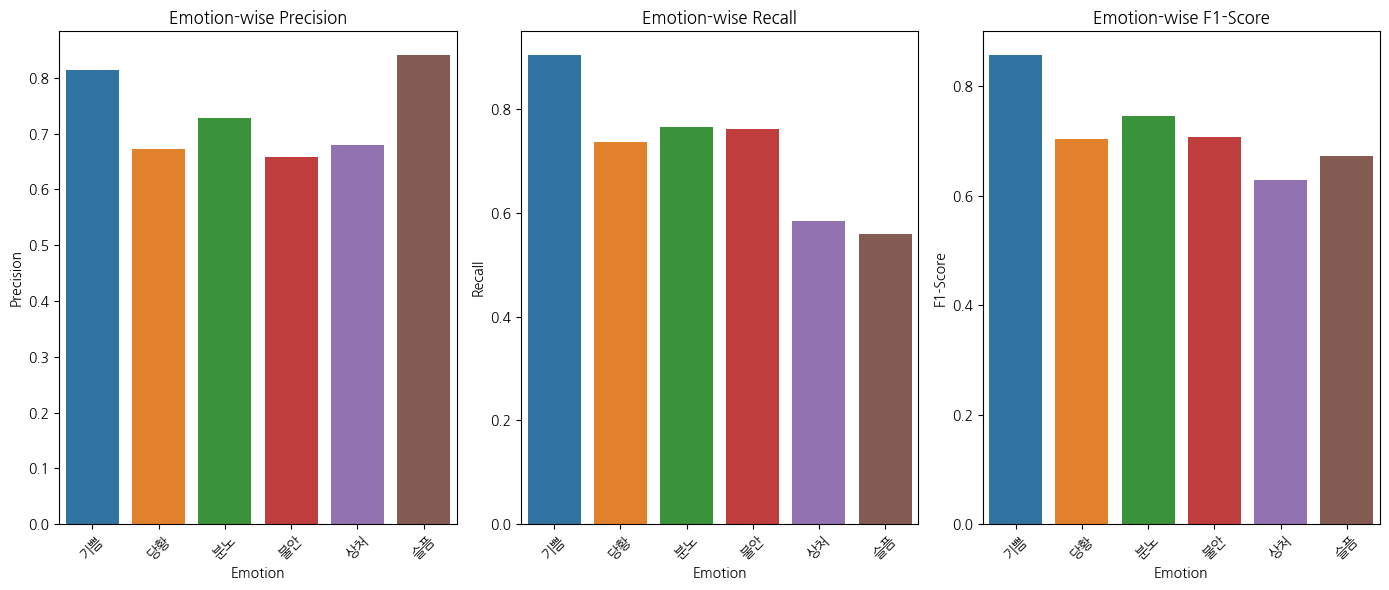

Overall Accuracy: 0.73


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로 설정
font_path = 'C:/Windows/Fonts/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# Seaborn을 사용한 감정별 평가 결과 시각화
ensemble_report = classification_report(y_validation_encoded, y_pred_ensemble, target_names=label_encoder.classes_, output_dict=True)
ensemble_report_df = pd.DataFrame(ensemble_report).transpose()

# 감정별 Precision, Recall, F1-Score 시각화
plt.figure(figsize=(14, 6))

# Precision
plt.subplot(1, 3, 1)
sns.barplot(x=ensemble_report_df.index[:-3], y=ensemble_report_df['precision'][:-3])
plt.xlabel('Emotion')
plt.ylabel('Precision')
plt.title('Emotion-wise Precision')
plt.xticks(rotation=45)

# Recall
plt.subplot(1, 3, 2)
sns.barplot(x=ensemble_report_df.index[:-3], y=ensemble_report_df['recall'][:-3])
plt.xlabel('Emotion')
plt.ylabel('Recall')
plt.title('Emotion-wise Recall')
plt.xticks(rotation=45)

# F1-Score
plt.subplot(1, 3, 3)
sns.barplot(x=ensemble_report_df.index[:-3], y=ensemble_report_df['f1-score'][:-3])
plt.xlabel('Emotion')
plt.ylabel('F1-Score')
plt.title('Emotion-wise F1-Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 전체 Accuracy 출력
overall_accuracy = accuracy_score(y_validation_encoded, y_pred_ensemble)
print(f"Overall Accuracy: {overall_accuracy:.2f}")